In [1]:
import numpy as np
import struct
import sys
import os
from vec_io import get_zeroled_names, read_vec
from vis_io import get_vtr, write_vtr, get_mesh, get_vtu, write_vtu, get_streamline_data, write_vtp, np_zeropad
import vtk
from tqdm import tqdm, trange
from vtkmodules.util import numpy_support
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


def plotLine(lines):
  # Data for a three-dimensional line
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  for sl in lines:
    ax.plot3D(sl[:,0], sl[:,1], sl[:,2])
  plt.show()
  plt.close('all')

In [ ]:
# DEMO: reanme e.g. 1.vec to 01.vec with get_zeroled_names
names, newnames = get_zeroled_names('data', '.vec', 1)
for name, newname in zip(names, newnames):
  os.rename(name, newname)

### Streamline Generation Tutorial
with tornado dataset at timestep 10.

#### 1. get vector field and seeds
tornado dataset is read to a vtkRectlinearGrid (.vtr) format

In [2]:
# generate seeds in every on each grid point of (1, 1, 1) 48 points total along each dimension
dim_coord = np.linspace(0, 1, 48, dtype=np.float32)
mesh = get_mesh(dim_coord,dim_coord,dim_coord)
mesh = mesh.reshape(-1, 3)
seeds = vtk.vtkPoints()
seeds.SetData(numpy_support.numpy_to_vtk(mesh.copy()))
# seed option 1: vtkPointSet
seeds_dataset = vtk.vtkPointSet()
seeds_dataset.SetPoints(seeds)
# seed option 2.1: vtkPointSource (seeds within a sphere)
seeds_source = vtk.vtkPointSource()
seeds_source.SetCenter(0.5, 0.5, 0.5)
seeds_source.SetRadius(0.1)
seeds_source.SetNumberOfPoints(10)
# seed option 2.2: vtkPointSource (seeds from vtkPointSet)
# seeds_source.SetInputData(seeds_dataset)


# get vector field in vtk format
vec_dir = 'data'
vec_paths = sorted([os.path.join(vec_dir, vec_file) for vec_file in os.listdir(vec_dir)])
# read_vec in vec_io.py
# read a .vec file (xdim, ydim, zdim, xv, yv, zv, xv, yv, zv, xv ...)
# to a numpy array of shape (xdim, ydim, zdim, 3)
vec0 = read_vec(vec_paths[0])
vec_dim_coord = np.linspace(0, 1, 48, dtype=np.float32)
vec_vtr = get_vtr(vec0.shape[:-1], vec_dim_coord, vec_dim_coord, vec_dim_coord, vector_fields={'velocity': vec0.reshape(-1, 3)})
# set active vector for vtkStreamTracer
vec_vtr.GetPointData().SetActiveVectors('velocity')


# OR: use vtkAssignAttribute to set the active vector
# specify the vector field for vtkStreamStracer
aa = vtk.vtkAssignAttribute()
ds = vtk.vtkDataSetAttributes()
aa.SetInputData(vec_vtr)
# 1=vtkDataSetAttribute::VECTOR
# 0=vtkAssignAttribute::POINT_DATA
aa.Assign('velocity', ds.VECTORS, aa.POINT_DATA)
aa.Update()

meshe generated: (48, 48, 48, 3)


In [3]:
# get stream tracer

# RungeKutta45 parameters
init_steplen = 0.2
tem_speed =1e-12
max_error = 1e-06
min_intsteplen = 0.01
max_intsteplen = 0.5
max_steps = 2000
max_length = 2

st = vtk.vtkStreamTracer()

# vector field input options:
# 1. vtkRectlinearGrid with .SetActiveVecotr()
st.SetInputData(vec_vtr)
# 2. vtkAssignAttribute with .Assign
# st.SetInputConnection(aa.GetOutputPort())

# seeds input options
# 1. start position of 1 seed
# st.SetStartPosition(0.5,0.5,0.5)
# 2. vtkPointSource
# st.SetSourceConnection(seeds_source.GetOutputPort())
# 3. vtkPointSet
st.SetSourceData(seeds_dataset)

# integrator parameters
integrator = vtk.vtkRungeKutta45()
st.SetIntegrator(integrator)
st.SetIntegrationDirectionToForward()
st.SetMaximumError(max_error)
st.SetIntegrationStepUnit(st.CELL_LENGTH_UNIT)
st.SetInitialIntegrationStep(init_steplen)
st.SetMinimumIntegrationStep(min_intsteplen)
st.SetMaximumIntegrationStep(max_intsteplen)
st.SetMaximumNumberOfSteps(max_steps)
st.SetMaximumPropagation(max_length)
st.SetTerminalSpeed(tem_speed)

# run the algorithm
st.Update()

# get the output streamline as vtkPolyData
pdm = st.GetOutput()
# check # of strealines produced
pdm.GetNumberOfCells()

98157

In [10]:
# option to write the vtkPolyData out with vis_io.write_vtp()
# write_vtp("data/vtksl.vtp", pdm)

In [4]:
# Optional Sanity Check: what's the reason sls terminates? find doc of vtkStreamTracer ot integrator

# value from 1-7
st.OUT_OF_DOMAIN
st.NOT_INITIALIZED
st.UNEXPECTED_VALUE
st.OUT_OF_LENGTH
st.OUT_OF_STEPS
st.STAGNATION
st.FIXED_REASONS_FOR_TERMINATION_COUNT

# check tem reasons
cd = pdm.GetCellData()
tem_reason = numpy_support.vtk_to_numpy(cd.GetArray(0)).copy()
tem_reason

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [5]:
'''
get 
1. list of streamlines as np arrays
2. length of each sl
3. id of each streamline with same length of the sl len
4. all sl points concatenated (N, 3)
5. all sl ids concatenated (N, 1)
'''
slvtk, lenvtk, _, pointsvtk, pointidsvtk = get_streamline_data(pdm)

100%|██████████| 98157/98157 [00:08<00:00, 12059.73it/s]


Average Line lengths (# of points): 27.53812769338916


In [7]:
# option to zero pad each sl to the max length of all, and output ot npy file
# with vis_io.np_zeropad()
slvtk_padded = [0]*len(slvtk)
max_len = int(lenvtk.max())
for i, sl in enumerate(slvtk):
  slvtk_padded[i] = np_zeropad(sl, max_len, 0)
  
# np.save("data/tornado10_sl.npy", slvtk_padded)
# np.save("data/tornado10_sllen.npy", lenvtk)

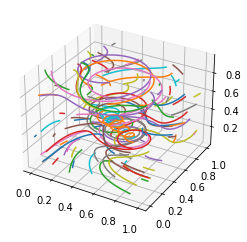

In [8]:
# option to visualize some of the streamlines
plotLine(slvtk[::1000])

### Optional: read steamlines from .vtp file exported from paraview

In [9]:
paraview_sl_paths = "data/tornado_streamline1.vtp"
paraview_sl_reader = vtk.vtkXMLPolyDataReader()
paraview_sl_reader.SetFileName(paraview_sl_paths)
paraview_sl_reader.Update()
paraview_sl = paraview_sl_reader.GetOutput()
paraview_sl.GetNumberOfCells()

1

In [12]:
slprv, lenprv, _, pointsprv, pointidsprv = get_streamline_data(paraview_sl)

100%|██████████| 1/1 [00:00<00:00, 1582.76it/s]

For this streamline --- max coord: 30.28680992126465      min coord: 11.198263168334961
Average Line lengths (# of points): 64.0


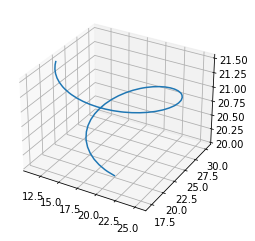

In [13]:
plotLine(slprv)